# User Journey Cohort Analysis (Web Session Data)

In [195]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

The original raw dataset for this project actually comes from **Google Analytics (BigQuery)**. It tracks website session data across all user visits for an entire year. This dataset is massive, so only 7 columns were extracted from BigQuery to prevent performance issues. They will be imported into this notebook in the following cell.

In [197]:
# Load data
google = pd.read_csv("google_merchandise_raw.csv")

C:\Users\dylan\AppData\Local\Temp\ipykernel_22068\316553378.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  google = pd.read_csv("google_merchandise_raw.csv")


In [198]:
# Preview the dataset
print(google.head(10))

         fullVisitorId     visitId  visitStartTime  hitNumber hit_type  \
0  6314382205896179631  1471627397      1471627397          2     PAGE   
1  6314382205896179631  1471627397      1471627397          8    EVENT   
2  6314382205896179631  1471627397      1471627397         14     PAGE   
3  6314382205896179631  1471627397      1471627397         17     PAGE   
4  6314382205896179631  1471627397      1471627397         18     PAGE   
5  6033983136147159594  1471592928      1471592928          1     PAGE   
6  6033983136147159594  1471592928      1471592928         13    EVENT   
7  6033983136147159594  1471592928      1471592928         15    EVENT   
8  3041133261614133977  1471654466      1471654466          6     PAGE   
9  3041133261614133977  1471654466      1471654466          9     PAGE   

                      page_path  revenue  
0                         /home      NaN  
1       /google+redesign/office      NaN  
2    /google+redesign/drinkware      NaN  
3  /google+re

### Initial Data Checks

In [200]:
# Number of rows and columns
print(google.shape)

(4153675, 7)


In [201]:
# Rename columns for clarity
google = google.rename(columns={
    'fullVisitorId': 'user_id',
    'visitId': 'session_id',
    'visitStartTime': 'session_start_time',
    'hitNumber': 'hit_number'
})

In [202]:
# Check data types
print(google.dtypes)

user_id                object
session_id              int64
session_start_time      int64
hit_number              int64
hit_type               object
page_path              object
revenue               float64
dtype: object


In [203]:
# Convert `session_start_time` from unix to datetime
google['session_start_time'] = pd.to_datetime(google['session_start_time'], unit='s')

In [204]:
# Convert `hit_type` entries to lowercase
google['hit_type'] = google['hit_type'].str.lower()

In [205]:
# Number of unique users
unique_users = google['user_id'].nunique()
print(f'Number of Unique Users: {unique_users}')

Number of Unique Users: 843049


In [206]:
# Number of unique sessions
unique_sessions = google['session_id'].nunique()
print(f'Number of Unique Sessions: {unique_sessions}')

Number of Unique Sessions: 886303


In [207]:
# Missing values by column
missing_values = google.isnull().sum()
print(f'Number of Missing Values (per column): \n{missing_values}')

Number of Missing Values (per column): 
user_id                     0
session_id                  0
session_start_time          0
hit_number                  0
hit_type                    0
page_path                   0
revenue               4141602
dtype: int64


In [208]:
# Duplicate rows
duplicates = google[google.duplicated()]
print(f'Number of Duplicate Rows: {len(duplicates)}')

Number of Duplicate Rows: 0


In [209]:
# Date range
start = google['session_start_time'].min()
end = google['session_start_time'].max()
print(f'Date Range: {start} thru {end}')

Date Range: 2016-08-01 07:00:12 thru 2017-08-02 06:59:53


### Initial cleaning done... ready for analysis

- **Rows:** 4,153,675
- **Columns:** 7
- **Unique Users:** 843,049
- **Unique Sessions:** 886,303
- **Missing Values:**
  - `revenue`: 4,141,602 🆗
- **Duplicate Rows:** 0 ✅
- **Date Range:** Aug 1, 2016 - Aug 2, 2017

The `revenue` column will **not** be used in this analysis, so these missing values are irrelevant.

# Analysis

### Purchase Rate by Path

In [213]:
# Build path lists for every session
session_paths = (
    google.sort_values(['user_id', 'session_id', 'hit_number']).groupby(['user_id', 'session_id'])['page_path'].apply(list).reset_index(name='path')
)

In [214]:
# Convert lists to strings
session_paths['path_strings'] = session_paths['path'].apply(lambda x: ' / '.join(x))

In [215]:
# Number of unique paths
unique_path_count = session_paths['path_strings'].nunique()
print(f'Number of Unique Paths: {unique_path_count}')

Number of Unique Paths: 247879


In [216]:
# Top 10 paths taken
top_paths = session_paths['path_strings'].value_counts().head(10)
print(top_paths)

path_strings
/home                                              345888
/home / /home                                       62844
/google+redesign/shop+by+brand/youtube              52290
/google+redesign/apparel/men++s/men++s+t+shirts     10917
/signin.html                                         8851
/home / /google+redesign/shop+by+brand/youtube       8426
/home / /home / /home                                8380
/google+redesign/apparel/mens/mens+t+shirts          7666
/basket.html                                         5793
/google+redesign/drinkware                           5738
Name: count, dtype: int64


In [217]:
# Path frequency
path_frequency = session_paths['path_strings'].value_counts().reset_index()
path_frequency.columns = ['path', 'frequency']

In [218]:
# Set a 'purchased' flag... either 'purchase' or 'no purchase'
purchased = google.groupby(['user_id', 'session_id'])['revenue'].max().notnull().astype(int).reset_index(name='purchased')

In [219]:
# Merge with session_paths df
paths_with_purchase = session_paths.merge(purchased, on=['user_id', 'session_id'])

In [220]:
# Find purchase rate for every path
path_stats = (
    paths_with_purchase.groupby('path_strings').agg(
        frequency=('path_strings', 'size'), purchases=('purchased', 'sum')).assign(
            purchase_rate=lambda df: df['purchases'] / df['frequency']
    ).reset_index()
)

In [221]:
# Display top 10 paths according to purchase rate
print(path_stats.sort_values('purchase_rate', ascending=False).head(10))

                                             path_strings  frequency  \
135310  /home / /google+redesign/apparel/mens/mens+t+s...          1   
150944  /home / /google+redesign/bags/water+bottles+an...          1   
136333  /home / /google+redesign/apparel/mens/mens+t+s...          1   
101288  /google+redesign/shop+by+brand/youtube / /goog...          1   
206662  /home / /home / /google+redesign/office / /sto...          1   
220446  /home / /home / /home / /google+redesign/shop+...          1   
101295  /google+redesign/shop+by+brand/youtube / /goog...          1   
236640  /home-2 / /google+redesign/apparel/women+s / /...          1   
12377   /google+redesign/accessories/stickers/home / /...          1   
236639  /home-2 / /google+redesign/apparel/women+s / /...          1   

        purchases  purchase_rate  
135310          1            1.0  
150944          1            1.0  
136333          1            1.0  
101288          1            1.0  
206662          1            1.0

**Note:** Overall, purchases are rare. The vast majority of paths are simply browsing and searching, etc. Therefore, only paths with **at least 1 purchase** will be explored next.

In [223]:
# Filter for paths with at least 1 purchase
purchases_only = path_stats[path_stats['purchases'] >= 1].sort_values('purchases', ascending=False)

In [224]:
# Preview paths with at least 1 purchase
print(purchases_only.head(10))

                                             path_strings  frequency  \
239499                               /ordercompleted.html         23   
109691  /home / /basket.html / /yourinfo.html / /payme...          7   
230334                       /home / /ordercompleted.html         10   
4866    /basket.html / /payment.html / /ordercompleted...          9   
247851  /yourinfo.html / /payment.html / /revieworder....          5   
239520               /payment.html / /ordercompleted.html          6   
4856                  /basket.html / /ordercompleted.html         12   
5083    /basket.html / /signin.html / /basket.html / /...          4   
239906           /revieworder.html / /ordercompleted.html          9   
147452  /home / /google+redesign/bags/backpacks/home /...          3   

        purchases  purchase_rate  
239499         11       0.478261  
109691          7       1.000000  
230334          6       0.600000  
4866            5       0.555556  
247851          5       1.000000

### Purchase Rate by Path Length

In [226]:
# Calculate path length for every session
session_paths['path_length'] = session_paths['path'].apply(len)

In [227]:
# Merge with 'purchased' flag
session_paths = session_paths.merge(purchased, on=['user_id', 'session_id'])

In [228]:
# Path length value counts
print(session_paths['path_length'].value_counts().sort_index())

path_length
1      538370
2      162924
3       81559
4       50014
5       35784
        ...  
436         1
437         1
471         1
483         1
500         4
Name: count, Length: 265, dtype: int64


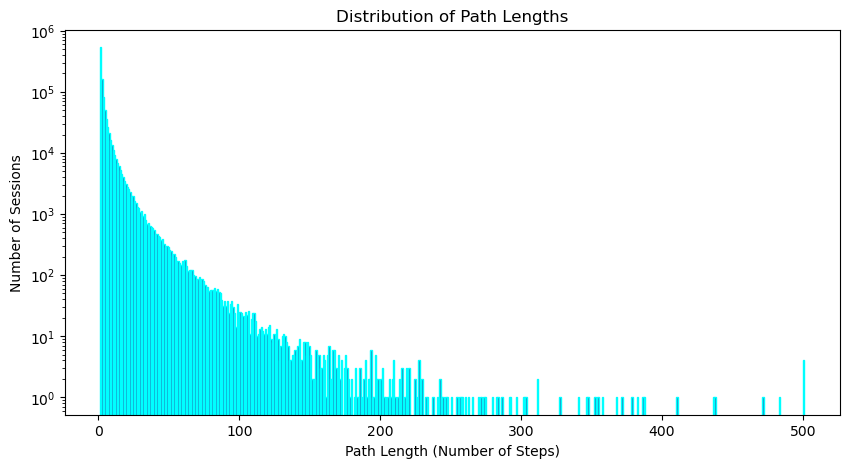

In [229]:
# Histogram ^

plt.figure(figsize=(10,5))
plt.hist(session_paths['path_length'], bins=range(1, session_paths['path_length'].max()+2), edgecolor='cyan')
plt.title('Distribution of Path Lengths')
plt.xlabel('Path Length (Number of Steps)')
plt.ylabel('Number of Sessions')
plt.yscale('log')
plt.show()

**Note:** A **log scale** was applied to the y-axis here because as path length (number of steps) increases, the number of sessions has an extreme drop off. Most y-axis values are quite small, so the *very few* large y-axis values would dominate this histogram without the log application.

In [231]:
# Put all path lengths into buckets
bins = [1, 2, 3, 4, 6, 11, 21, 51, session_paths['path_length'].max() + 1]
labels = ['1', '2', '3', '4-5', '6-10', '11-20', '21-50', '51+']

# New buckets column
session_paths['path_length_bucket'] = pd.cut(session_paths['path_length'], bins=bins, labels=labels, right=False)

In [232]:
# Calculate purchase rate by bucket
purchase_by_bucket = (
    session_paths.groupby('path_length_bucket').agg(
        sessions=('path_length', 'count'), purchases=('purchased', 'sum')).assign(
        purchase_rate=lambda x: x['purchases'] / x['sessions']).reset_index()
)

C:\Users\dylan\AppData\Local\Temp\ipykernel_22068\4212334518.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_paths.groupby('path_length_bucket').agg(


In [233]:
# Find % of total purchases
total_purchases = purchase_by_bucket['purchases'].sum()

purchase_by_bucket['pct_of_total_purchases'] = (purchase_by_bucket['purchases'] / total_purchases * 100).round(2)

  path_length_bucket  sessions  purchases  purchase_rate  \
0                  1    538370         11       0.000020   
1                  2    162924         38       0.000233   
2                  3     81559         88       0.001079   
3                4-5     85798        263       0.003065   
4               6-10     88668       1083       0.012214   
5              11-20     53233       3605       0.067721   
6              21-50     27202       4867       0.178921   
7                51+      5265       1638       0.311111   

   pct_of_total_purchases  
0                    0.09  
1                    0.33  
2                    0.76  
3                    2.27  
4                    9.34  
5                   31.10  
6                   41.98  
7                   14.13  


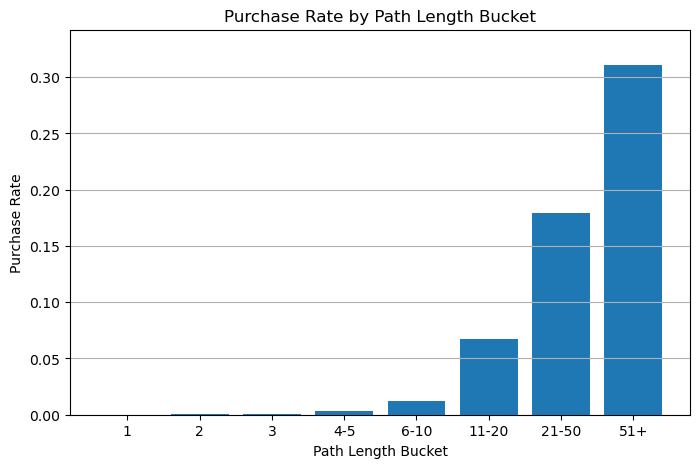

In [234]:
# Display purchase rate by bucket
print(purchase_by_bucket)

# Plot results
plt.figure(figsize=(8,5))
plt.bar(purchase_by_bucket['path_length_bucket'], purchase_by_bucket['purchase_rate'])
plt.title('Purchase Rate by Path Length Bucket')
plt.xlabel('Path Length Bucket')
plt.ylabel('Purchase Rate')
plt.ylim(0, purchase_by_bucket['purchase_rate'].max() * 1.1)  # adjusted scale
plt.grid(axis='y')
plt.show()

**Results:** Sessions with **more steps** (i.e., longer user journeys) are far more likely to **result in a purchase** than shorter sessions.

### Drop-Off % at Each Step

In [237]:
# Calculate number of sessions that reach each step number (i.e., Step 1, Step 2, ...), generally speaking
session_lengths = session_paths['path_length']
max_length = session_lengths.max()

In [238]:
# For each step n, count number of sessions that made it to step n or further
sessions_at_least_n = [(session_lengths >= n).sum() for n in range(1, max_length + 1)]

In [239]:
# Calculate drop-off percentage between steps
dropoff_pct = [
    1 - (sessions_at_least_n[n] / sessions_at_least_n[n-1]) if n > 0 else 0 for n in range(len(sessions_at_least_n))
]

In [240]:
# Create DataFrame
step_dropoff = pd.DataFrame({
    'step_number': range(1, len(sessions_at_least_n) + 1),
    'sessions_remaining': sessions_at_least_n,
    'dropoff_pct': dropoff_pct
})

    step_number  sessions_remaining  dropoff_pct
0             1             1043019     0.000000
1             2              504649     0.516165
2             3              341725     0.322846
3             4              260166     0.238669
4             5              210152     0.192239
5             6              174368     0.170277
6             7              147629     0.153348
7             8              126773     0.141273
8             9              110285     0.130059
9            10               96714     0.123054
10           11               85700     0.113882
11           12               76283     0.109883
12           13               68353     0.103955
13           14               61578     0.099118
14           15               55575     0.097486
15           16               50318     0.094593
16           17               45851     0.088775
17           18               41830     0.087697
18           19               38387     0.082309
19           20     

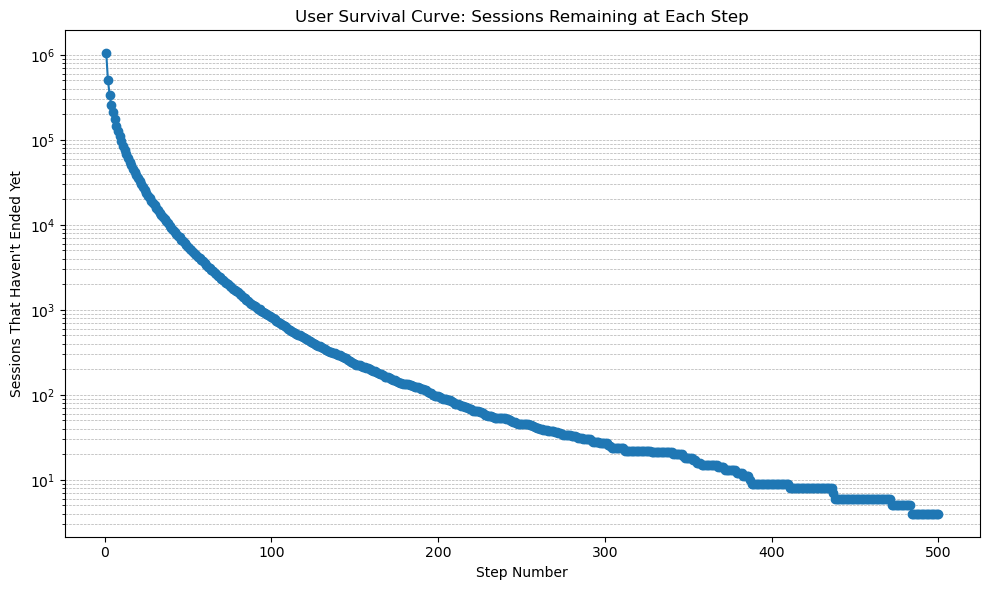

In [241]:
# Preview drop-off % at each step... first 20 steps
print(step_dropoff.head(20))

# Plot results for all steps
plt.figure(figsize=(10,6))
plt.plot(step_dropoff['step_number'], step_dropoff['sessions_remaining'], marker='o')
plt.title('User Survival Curve: Sessions Remaining at Each Step')
plt.xlabel('Step Number')
plt.ylabel("Sessions That Haven't Ended Yet")
plt.yscale('log')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

**Note:** A **log scale** was applied to the y-axis here because most y-axis values are small. The *very few* large y-axis values would dominate this plot without the log application.

**Results:** **Over 50%** of **user sessions** conclude at the end of step 1. Most user sessions are rather short. Extended user sessions are relatively rare, but as seen in Purchase Rate by Pair Length Bucket, the **longer** a session, the more likely it will **result in a purchase**.

### Cohort Analysis... additional columns import from BigQuery

After the initial export to Tableau, the "big picture" analysis fell short, in my opinion. Therefore, 4 new columns were extracted (plus the primary key column) from the raw dataset in BigQuery. This slices the notebook's primary dataset into **4 separate cohorts** based on **how users accessed the site**. The import will take place in the next cell below.

In [245]:
# Load data
google_2 = pd.read_csv("google_merchandise_cohort_columns.csv")

In [246]:
# Rename columns for clarity
google_2 = google_2.rename(columns={
    'visitId': 'session_id',
    'pagePath': 'page_path',
    'pagePathLevel1': 'page_path_entry'
})  

In [247]:
# Remove duplicate rows
google_2_entry = google_2.drop_duplicates(subset='session_id', keep='first')

In [248]:
# Merge with session_paths (session-level data already here in the Jupyter notebook)
final_merge = session_paths.merge(google_2_entry, on='session_id', how='left')

In [249]:
# Preview final merged dataset
final_merge.head(10)

,user_id,session_id,path,path_strings,path_length,purchased,path_length_bucket,source,medium,page_path,page_path_entry
0,4823595352351,1478011510,[/home],/home,1,0,1,baidu,organic,/home,/home
1,5103959234087,1471817208,"[/home, /home, /google+redesign/fruit-games, /...",/home / /home / /google+redesign/fruit-games /...,10,0,6-10,google,organic,/home,/home
2,10278554503158,1477029466,"[/home, /google+redesign/electronics/power, /g...",/home / /google+redesign/electronics/power / /...,11,0,11-20,google,organic,/home,/home
3,20424342248747,1480578901,"[/home, /home, /home, /google+redesign/shop+by...",/home / /home / /home / /google+redesign/shop+...,17,0,11-20,(direct),(none),/home,/home
4,26722803385797,1496658394,"[/google+redesign/shop+by+brand/youtube, /goog...",/google+redesign/shop+by+brand/youtube / /goog...,2,0,2,google,organic,/google+redesign/shop+by+brand/youtube,/google+redesign/
5,27376579751715,1486866293,"[/home, /google+redesign/shop+by+brand/google,...",/home / /google+redesign/shop+by+brand/google ...,5,0,4-5,(direct),(none),/home,/home
6,35794135966385,1484916385,[/home],/home,1,0,1,(direct),(none),/home,/home
7,39460501403861,1490629516,"[/home, /home]",/home / /home,2,0,2,youtube.com,referral,/home,/home
8,40862739425590,1486836571,[/home],/home,1,0,1,(direct),(none),/google redesign/apparel/men s/men s t shirts,/google redesign/
9,40862739425590,1486838824,"[/store.html, /google+redesign/apparel/kid+s/k...",/store.html / /google+redesign/apparel/kid+s/k...,2,0,2,(direct),(none),/google+redesign/apparel/men++s/men++s+outerwear,/google+redesign/


In [250]:
# Number of rows and columns
print(final_merge.shape)

(1043019, 11)


In [251]:
# Confirm number of unique sessions
unique_sessions_final = final_merge['session_id'].nunique()
print(f'Number of Unique Sessions: {unique_sessions}')

Number of Unique Sessions: 886303


### Purchase Rate by Traffic Source

In [253]:
# Calculate purchase rate by traffic source
purchase_by_source = (
    final_merge.groupby('source').agg(
        sessions=('session_id', 'count'), purchases=('purchased', 'sum')).assign(
        purchase_rate=lambda x: x['purchases'] / x['sessions']).reset_index()
)

In [254]:
# Summary stats for number of sessions
summary = purchase_by_source['sessions'].describe()
print(summary.apply(lambda x: f'{x:,.0f}'))

count        275
mean       3,793
std       34,453
min            1
25%            2
50%            6
75%           36
max      445,736
Name: sessions, dtype: object


In [255]:
# Filter for top 20 traffic sources with 100+ sessions
purchase_by_source_filtered = purchase_by_source[purchase_by_source['sessions'] >= 100]

# Display top 20 traffic sources by purchase rate
print(purchase_by_source_filtered.sort_values('purchase_rate', ascending=False).head(20))

                        source  sessions  purchases  purchase_rate
50               dealspotr.com       643         40       0.062208
179            mail.google.com      1814         64       0.035281
128          groups.google.com      1262         39       0.030903
42   connect.googleforwork.com       122          3       0.024590
209              phandroid.com       269          6       0.022305
0                     (direct)    445736       8776       0.019689
53                         dfa      6858        121       0.017644
159             l.facebook.com       939         16       0.017039
271                      yahoo      1772         23       0.012980
13                         ask       315          4       0.012698
237           sites.google.com      3653         45       0.012319
21                        bing      1848         21       0.011364
207           outlook.live.com       103          1       0.009709
211            plus.google.com       626          6       0.00

### Purchase Rate by Traffic Medium

In [257]:
# Calculate purchase rate by traffic medium
purchase_by_medium = (
    final_merge.groupby('medium').agg(
        sessions=('session_id', 'count'), purchases=('purchased', 'sum')).assign(
            purchase_rate=lambda x: x['purchases'] / x['sessions']).reset_index()
)

In [258]:
# Filter for top traffic mediums with 100+ sessions
purchase_by_medium_filtered = purchase_by_medium[purchase_by_medium['sessions'] >= 100]

# Display top traffic mediums by purchase rate
print(purchase_by_medium_filtered.sort_values('purchase_rate', ascending=False))

      medium  sessions  purchases  purchase_rate
0     (none)    445734       8776       0.019689
4        cpm      7506        137       0.018252
3        cpc     16049        238       0.014830
5    organic    274352       2114       0.007705
1  (not set)       149          1       0.006711
6   referral    280505        318       0.001134
2  affiliate     18724          9       0.000481


### Purchase Rate by Traffic Source & Traffic Medium

In [260]:
# Calculate purchase rate by both traffic source and traffic medium
purchase_by_source_and_medium = (
    final_merge.groupby(['source', 'medium']).agg(
        sessions=('session_id', 'count'), purchases=('purchased', 'sum')).assign(
            purchase_rate=lambda x: x['purchases'] / x['sessions']).reset_index()
)

In [261]:
# Filter for top traffic source and medium combinations with 100+ sessions
purchase_by_source_and_medium_filtered = purchase_by_source_and_medium[purchase_by_source_and_medium['sessions'] >= 100]

# Display top 15 combinations by purchase rate
purchase_by_source_and_medium_filtered.sort_values('purchase_rate',ascending=False).head(15)

,source,medium,sessions,purchases,purchase_rate
53,dealspotr.com,referral,643,40,0.062208
185,mail.google.com,referral,1814,64,0.035281
134,groups.google.com,referral,1262,39,0.030903
82,google,cpm,646,16,0.024768
45,connect.googleforwork.com,referral,122,3,0.024590
215,phandroid.com,referral,269,6,0.022305
0,(direct),(none),445734,8776,0.019689
56,dfa,cpm,6858,121,0.017644
165,l.facebook.com,referral,939,16,0.017039
81,google,cpc,16048,238,0.014831


### Purchase Rate by Entry Page

In [263]:
# Calculate purchase rate by both traffic source and traffic medium
purchase_by_entry_page = (
    final_merge.groupby('page_path_entry').agg(
        sessions=('session_id', 'count'), purchases=('purchased', 'sum')).assign(
            purchase_rate=lambda x: x['purchases'] / x['sessions']).reset_index()
)

In [264]:
# Filter for top entry pages with 100+ sessions
purchase_by_entry_page_filtered = purchase_by_entry_page[purchase_by_entry_page['sessions'] >= 100]

# Display top entry pages by purchase rate
print(purchase_by_entry_page_filtered.sort_values('purchase_rate', ascending=False))

                        page_path_entry  sessions  purchases  purchase_rate
15  /myaccount.html?mode=billingaddress       402         93       0.231343
2                          /basket.html     11483        807       0.070278
23                       /register.html       240         15       0.062500
31                          /store.html      5201        319       0.061334
33                      /storeitem.html       141          8       0.056738
11                              /home-2      6033        320       0.053042
7                     /google redesign/      3147         53       0.016841
0                         /asearch.html      3470         47       0.013545
28                         /signin.html     19638        207       0.010541
10                                /home    707247       6962       0.009844
8                     /google+redesign/    282988       2707       0.009566
30                     /store-policies/      2274          9       0.003958
27          

In [265]:
# List of checkout-related pages to exclude from results
checkout_pages = [
    '/yourinfo.html',
    '/payment.html',
    '/myaccount.html',
    '/registersuccess.html',
    '/basket.html',
    '/store.html',
    '/register.html',
    '/myaccount.html?mode=billingaddress'
]

# Filter the DataFrame
non_checkout = purchase_by_entry_page_filtered[~purchase_by_entry_page_filtered['page_path_entry'].isin(checkout_pages)]

# Display results... top 10 by purchase rate
print(non_checkout.sort_values('purchase_rate', ascending=False).head(10))

      page_path_entry  sessions  purchases  purchase_rate
33    /storeitem.html       141          8       0.056738
11            /home-2      6033        320       0.053042
7   /google redesign/      3147         53       0.016841
0       /asearch.html      3470         47       0.013545
28       /signin.html     19638        207       0.010541
10              /home    707247       6962       0.009844
8   /google+redesign/    282988       2707       0.009566
30   /store-policies/      2274          9       0.003958
27         /shop.axd/       256          0       0.000000


**Note:** The **entry page** is the *very first page* a user lands on when starting a session on the website.
> For example, if a user clicks a Google advertisement for a particular product and lands on "/product/widget.html," then this is the entry page for their session.

## 4 Cohorts based on Traffic Medium

In [268]:
# Assign cohorts
def medium_cohort(m):
    if m == '(none)':
        return 'Direct'
    elif m in ['cpm', 'cpc']:
        return 'Paid'
    elif m == 'organic':
        return 'Organic'
    elif m == 'referral':
        return 'Referral'
    else:
        return 'Other'

final_merge['medium_cohort'] = final_merge['medium'].apply(medium_cohort)

In [269]:
# Calculate sessions, purchases, and purchase rate for all cohorts
cohort_summary = (
    final_merge.groupby('medium_cohort').agg(
        sessions=('session_id', 'nunique'), purchases=('purchased', 'sum')).assign(
            purchase_rate=lambda x: x['purchases'] / x['sessions']).reset_index()
)

In [270]:
# Display cohort summary table
cohort_summary.sort_values('purchase_rate', ascending=False)

,medium_cohort,sessions,purchases,purchase_rate
0,Direct,366371,8776,0.023954
3,Paid,18828,375,0.019917
1,Organic,229609,2114,0.009207
4,Referral,255297,318,0.001246
2,Other,16198,10,0.000617


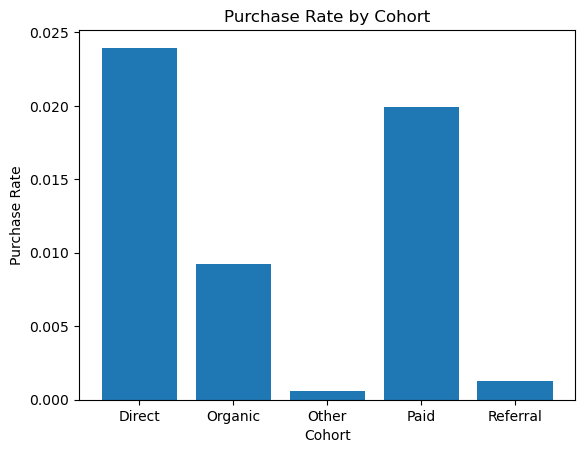

In [271]:
# Plot results
plt.bar(cohort_summary['medium_cohort'], cohort_summary['purchase_rate'])
plt.title('Purchase Rate by Cohort')
plt.xlabel('Cohort')
plt.ylabel('Purchase Rate')
plt.show()

#### Cohort Descriptions

- **Direct:**
  Users who arrived by typing the website URL *directly* into their browser, using bookmarks, or in ways that bypass any tracked referring site.

- **Paid:**
  Users who clicked on paid advertisements, such as search engine ads (CPC, CPM) or display ads.

- **Organic:**
  Users who found the site via unpaid search results, such as Google or Bing.

- **Referral:**
  Users who accessed the site by clicking a link on a different (non-affiliated) website.

- **Other:**
  Any remaining traffic not captured by the four main categories above, often including miscategorized, rare, or unknown traffic sources. (This will be filtered out in the final Tableau dashboard.)

### Drop-Off % at Each Step... broken down by each cohort

In [274]:
# This DataFrame will be recreated with an appended cohort column
step_dropoff

,step_number,sessions_remaining,dropoff_pct
0,1,1043019,0.000000
1,2,504649,0.516165
2,3,341725,0.322846
3,4,260166,0.238669
4,5,210152,0.192239
...,...,...,...
495,496,4,0.000000
496,497,4,0.000000
497,498,4,0.000000
498,499,4,0.000000


In [275]:
# Extract cohort labels from the final merged dataset
cohorts = final_merge['medium_cohort'].unique()

In [276]:
# Loop through each cohort and compute the drop-off
max_length_ = final_merge['path_length'].max()
max_steps = 500
step_numbers = list(range(1, max_length_ + 1))
results = []

for cohort in cohorts:
    df = final_merge[final_merge['medium_cohort'] == cohort]
    session_lengths_ = df.groupby('session_id')['path_length'].max()
    
    sessions_at_least_n_ = [(session_lengths_ >= n).sum() for n in range(1, max_length_ + 1)]
    dropoff_pct_ = [
        1 - (sessions_at_least_n_[n] / sessions_at_least_n_[n-1]) if n > 0 and sessions_at_least_n_[n-1] > 0 else 0 for n in range(len(sessions_at_least_n_))
    ]

    assert len(sessions_at_least_n_) == max_steps
    assert len(dropoff_pct_) == max_steps
    
    # Create cohort df
    cohort_info = pd.DataFrame({
        'step_number': step_numbers,
        'sessions_remaining_': sessions_at_least_n_,
        'dropoff_pct': dropoff_pct_,
        'cohort': [cohort] * max_steps
    })
    results.append(cohort_info)

In [277]:
# Concatenate and display dropoff % by step (with cohort labels now)
cohort_funnel = pd.concat(results, ignore_index=True)
cohort_funnel

,step_number,sessions_remaining_,dropoff_pct,cohort
0,1,229609,0.000000,Organic
1,2,112641,0.509423,Organic
2,3,82304,0.269325,Organic
3,4,64150,0.220573,Organic
4,5,53106,0.172159,Organic
...,...,...,...,...
2495,496,0,0.000000,Paid
2496,497,0,0.000000,Paid
2497,498,0,0.000000,Paid
2498,499,0,0.000000,Paid


### Final Export to Tableau

In [279]:
# Save the two primary DataFrames as CSVs
cohort_funnel.to_csv('dropoff_by_cohort.csv', index=False)
final_merge.to_csv('final_merged_dataset.csv', index=False)

These two CSVs will be opened in Tableau to create the final dashboard.